# Legendre Memory Units

In [1]:
# -*- coding: utf-8 -*-
"""LMU for Stock Price Prediction

Adapted from original LMU implementation for psMNIST
Now uses Yahoo Finance stock data for sequence prediction
"""

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from scipy.signal import cont2discrete
import yfinance as yf
from datetime import datetime, timedelta


In [2]:

# ============================================================================
# LMU Core Components (unchanged from original)
# ============================================================================

def leCunUniform(tensor):
    """LeCun Uniform Initializer"""
    fan_in = init._calculate_correct_fan(tensor, "fan_in")
    limit = np.sqrt(3. / fan_in)
    init.uniform_(tensor, -limit, limit)


class LMUCell(nn.Module):
    """A single LMU Cell"""

    def __init__(self, input_size, hidden_size, memory_size, theta, learn_a=False, learn_b=False, psmnist=False):
        super(LMUCell, self).__init__()

        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.f = nn.Tanh()

        A, B = self.stateSpaceMatrices(memory_size, theta)
        A = torch.from_numpy(A).float()
        B = torch.from_numpy(B).float()

        if learn_a:
            self.A = nn.Parameter(A)
        else:
            self.register_buffer("A", A)

        if learn_b:
            self.B = nn.Parameter(B)
        else:
            self.register_buffer("B", B)

        # Declare Model parameters:
        self.e_x = nn.Parameter(torch.empty(1, input_size))
        self.e_h = nn.Parameter(torch.empty(1, hidden_size))
        self.e_m = nn.Parameter(torch.empty(1, memory_size))
        self.W_x = nn.Parameter(torch.empty(hidden_size, input_size))
        self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.W_m = nn.Parameter(torch.empty(hidden_size, memory_size))

        self.initParameters(psmnist)

    def initParameters(self, psmnist=False):
        """Initialize the cell's parameters"""
        if psmnist:
            leCunUniform(self.e_x)
            init.constant_(self.e_h, 0)
            init.constant_(self.e_m, 0)
            init.constant_(self.W_x, 0)
            init.constant_(self.W_h, 0)
            init.xavier_normal_(self.W_m)
        else:
            leCunUniform(self.e_x)
            leCunUniform(self.e_h)
            init.constant_(self.e_m, 0)
            init.xavier_normal_(self.W_x)
            init.xavier_normal_(self.W_h)
            init.xavier_normal_(self.W_m)

    def stateSpaceMatrices(self, memory_size, theta):
        """Returns the discretized state space matrices A and B"""
        Q = np.arange(memory_size, dtype=np.float64).reshape(-1, 1)
        R = (2*Q + 1) / theta
        i, j = np.meshgrid(Q, Q, indexing="ij")

        A = R * np.where(i < j, -1, (-1.0)**(i - j + 1))
        B = R * ((-1.0)**Q)
        C = np.ones((1, memory_size))
        D = np.zeros((1,))

        A, B, C, D, dt = cont2discrete(
            system=(A, B, C, D),
            dt=1.0,
            method="zoh"
        )

        return A, B

    def forward(self, x, state):
        h, m = state
        u = F.linear(x, self.e_x) + F.linear(h, self.e_h) + F.linear(m, self.e_m)
        m = F.linear(m, self.A) + F.linear(u, self.B)
        h = self.f(
            F.linear(x, self.W_x) +
            F.linear(h, self.W_h) +
            F.linear(m, self.W_m)
        )
        return h, m


class LMU(nn.Module):
    """An LMU layer"""

    def __init__(self, input_size, hidden_size, memory_size, theta, learn_a=False, learn_b=False, psmnist=False):
        super(LMU, self).__init__()
        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.cell = LMUCell(input_size, hidden_size, memory_size, theta, learn_a, learn_b, psmnist)

    def forward(self, x, state=None):
        batch_size = x.size(0)
        seq_len = x.size(1)

        if state is None:
            h_0 = torch.zeros(batch_size, self.hidden_size)
            m_0 = torch.zeros(batch_size, self.memory_size)
            if x.is_cuda:
                h_0 = h_0.cuda()
                m_0 = m_0.cuda()
            state = (h_0, m_0)

        output = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t, m_t = self.cell(x_t, state)
            state = (h_t, m_t)
            output.append(h_t)

        output = torch.stack(output)
        output = output.permute(1, 0, 2)

        return output, state



In [7]:

# ============================================================================
# Stock Data Components (NEW)
# ============================================================================

class StockDataset(Dataset):
    """Dataset for stock price sequences"""

    def __init__(self, data, sequence_length, prediction_horizon=1):
        """
        Args:
            data: numpy array of shape [n_samples, n_features]
            sequence_length: length of input sequence
            prediction_horizon: number of steps to predict ahead
        """
        self.data = data
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

    def __len__(self):
        return len(self.data) - self.sequence_length - self.prediction_horizon + 1

    def __getitem__(self, idx):
        # Input: sequence of length sequence_length
        x = self.data[idx:idx + self.sequence_length]
        # Target: next value(s) after the sequence
        y = self.data[idx + self.sequence_length:idx + self.sequence_length + self.prediction_horizon]

        return torch.FloatTensor(x), torch.FloatTensor(y)


def download_stock_data(tickers, start_date, end_date):
    """
    Download stock data from Yahoo Finance

    Args:
        tickers: list of stock ticker symbols
        start_date: start date (string format: 'YYYY-MM-DD')
        end_date: end date (string format: 'YYYY-MM-DD')

    Returns:
        pandas DataFrame with stock data
    """
    print(f"Downloading data for {len(tickers)} stocks...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=True)

    # Use adjusted close prices
    if len(tickers) > 1:
        prices = data['Close']
    else:
        prices = data[['Close']]
        prices.columns = tickers

    # Remove any NaN values
    prices = prices.dropna()

    print(f"Downloaded {len(prices)} days of data")
    return prices


def normalize_data(data, method='minmax'):
    """
    Normalize the data

    Args:
        data: numpy array or pandas DataFrame
        method: 'minmax' or 'zscore'

    Returns:
        normalized data, mean, std (or min, max)
    """
    if method == 'minmax':
        min_val = data.min(axis=0)
        max_val = data.max(axis=0)
        normalized = (data - min_val) / (max_val - min_val + 1e-8)
        return normalized, min_val, max_val
    elif method == 'zscore':
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        normalized = (data - mean) / (std + 1e-8)
        return normalized, mean, std


def denormalize_data(normalized_data, min_val, max_val, method='minmax'):
    """Denormalize the data back to original scale"""
    if method == 'minmax':
        return normalized_data * (max_val - min_val) + min_val
    elif method == 'zscore':
        return normalized_data * max_val + min_val  # max_val is std, min_val is mean




In [8]:
# ============================================================================
# Model for Stock Prediction (ADAPTED)
# ============================================================================

class StockPredictionModel(nn.Module):
    """LMU-based model for stock price prediction"""

    def __init__(self, input_size, output_size, hidden_size, memory_size, theta,
                 learn_a=False, learn_b=False, prediction_horizon=1):
        super(StockPredictionModel, self).__init__()
        self.lmu = LMU(input_size, hidden_size, memory_size, theta, learn_a, learn_b, psmnist=False)
        self.prediction_horizon = prediction_horizon
        # Predict multiple timesteps if needed
        self.predictor = nn.Linear(hidden_size, output_size * prediction_horizon)

    def forward(self, x):
        _, (h_n, _) = self.lmu(x)  # [batch_size, hidden_size]
        output = self.predictor(h_n)  # [batch_size, output_size * prediction_horizon]

        if self.prediction_horizon > 1:
            # Reshape to [batch_size, prediction_horizon, output_size]
            batch_size = output.size(0)
            output = output.view(batch_size, self.prediction_horizon, -1)

        return output



In [9]:

# ============================================================================
# Training Functions (ADAPTED)
# ============================================================================

def countParameters(model):
    """Counts and prints the number of trainable and non-trainable parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")


def train(model, loader, optimizer, criterion, device):
    """A single training epoch"""
    epoch_loss = 0
    model.train()

    for batch, targets in tqdm(loader, desc="Training"):
        batch = batch.to(device)
        targets = targets.to(device)

        # Flatten targets if prediction_horizon > 1
        if len(targets.shape) > 2:
            targets = targets.view(targets.size(0), -1)

        optimizer.zero_grad()
        output = model(batch)

        # Reshape output to match targets
        if len(output.shape) > 2:
            output = output.view(output.size(0), -1)

        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    return avg_epoch_loss


def validate(model, loader, criterion, device):
    """A single validation epoch"""
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
        for batch, targets in tqdm(loader, desc="Validating"):
            batch = batch.to(device)
            targets = targets.to(device)

            # Flatten targets if prediction_horizon > 1
            if len(targets.shape) > 2:
                targets = targets.view(targets.size(0), -1)

            output = model(batch)

            # Reshape output to match targets
            if len(output.shape) > 2:
                output = output.view(output.size(0), -1)

            loss = criterion(output, targets)
            epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(loader)
    return avg_epoch_loss



/tmp/ipython-input-1893911357.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, progress=True)
[**********************50%                       ]  5 of 10 completed

Using GPU: Tesla T4


[*********************100%***********************]  10 of 10 completed


Downloaded 751 days of data

Stock data shape: (751, 10)
Columns: ['AAPL', 'AMZN', 'GOOGL', 'JPM', 'META', 'MSFT', 'NVDA', 'TSLA', 'V', 'WMT']

Train data: (600, 10)
Validation data: (151, 10)

Training samples: 540
Validation samples: 91
The model has 27,348 trainable parameters and 0 frozen parameters

Starting training...

Epoch: 01/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 39.11it/s]


Train Loss: 0.032333 | Val Loss: 0.025603
✓ Saved best model

Epoch: 02/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 38.34it/s]


Train Loss: 0.006701 | Val Loss: 0.025275
✓ Saved best model

Epoch: 03/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.59it/s]


Train Loss: 0.004484 | Val Loss: 0.025860

Epoch: 04/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 54.88it/s]


Train Loss: 0.003562 | Val Loss: 0.024724
✓ Saved best model

Epoch: 05/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 55.91it/s]


Train Loss: 0.002978 | Val Loss: 0.027141

Epoch: 06/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 42.89it/s]


Train Loss: 0.002929 | Val Loss: 0.023399
✓ Saved best model

Epoch: 07/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.58it/s]


Train Loss: 0.002515 | Val Loss: 0.027886

Epoch: 08/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.86it/s]


Train Loss: 0.002428 | Val Loss: 0.024958

Epoch: 09/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.72it/s]


Train Loss: 0.002122 | Val Loss: 0.024641

Epoch: 10/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 59.84it/s]


Train Loss: 0.001818 | Val Loss: 0.024739

Epoch: 11/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.36it/s]


Train Loss: 0.001710 | Val Loss: 0.022598
✓ Saved best model

Epoch: 12/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.09it/s]


Train Loss: 0.001667 | Val Loss: 0.022754

Epoch: 13/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 59.32it/s]


Train Loss: 0.001590 | Val Loss: 0.023698

Epoch: 14/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 44.71it/s]


Train Loss: 0.001669 | Val Loss: 0.022360
✓ Saved best model

Epoch: 15/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 44.51it/s]


Train Loss: 0.001483 | Val Loss: 0.022439

Epoch: 16/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.83it/s]


Train Loss: 0.001479 | Val Loss: 0.024300

Epoch: 17/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 63.03it/s]


Train Loss: 0.001490 | Val Loss: 0.020167
✓ Saved best model

Epoch: 18/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.59it/s]


Train Loss: 0.001340 | Val Loss: 0.020456

Epoch: 19/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 63.27it/s]


Train Loss: 0.001204 | Val Loss: 0.019933
✓ Saved best model

Epoch: 20/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 46.76it/s]


Train Loss: 0.001171 | Val Loss: 0.021913

Epoch: 21/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.20it/s]


Train Loss: 0.001192 | Val Loss: 0.018860
✓ Saved best model

Epoch: 22/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.93it/s]


Train Loss: 0.001076 | Val Loss: 0.019775

Epoch: 23/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 63.42it/s]


Train Loss: 0.001059 | Val Loss: 0.019690

Epoch: 24/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.78it/s]


Train Loss: 0.001216 | Val Loss: 0.017352
✓ Saved best model

Epoch: 25/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.10it/s]


Train Loss: 0.001184 | Val Loss: 0.019547

Epoch: 26/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 43.86it/s]


Train Loss: 0.001149 | Val Loss: 0.020352

Epoch: 27/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 41.29it/s]


Train Loss: 0.001057 | Val Loss: 0.019894

Epoch: 28/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.46it/s]


Train Loss: 0.000947 | Val Loss: 0.018924

Epoch: 29/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.55it/s]


Train Loss: 0.000932 | Val Loss: 0.019489

Epoch: 30/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.95it/s]


Train Loss: 0.000933 | Val Loss: 0.020504

Epoch: 31/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.72it/s]


Train Loss: 0.000936 | Val Loss: 0.020477

Epoch: 32/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 54.74it/s]


Train Loss: 0.000901 | Val Loss: 0.017947

Epoch: 33/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.72it/s]


Train Loss: 0.000964 | Val Loss: 0.017811

Epoch: 34/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 41.66it/s]


Train Loss: 0.000853 | Val Loss: 0.017182
✓ Saved best model

Epoch: 35/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.42it/s]


Train Loss: 0.000999 | Val Loss: 0.017305

Epoch: 36/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.85it/s]


Train Loss: 0.000962 | Val Loss: 0.016873
✓ Saved best model

Epoch: 37/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.91it/s]


Train Loss: 0.000813 | Val Loss: 0.016474
✓ Saved best model

Epoch: 38/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.15it/s]


Train Loss: 0.000818 | Val Loss: 0.016900

Epoch: 39/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 47.52it/s]


Train Loss: 0.000780 | Val Loss: 0.015870
✓ Saved best model

Epoch: 40/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.43it/s]


Train Loss: 0.000755 | Val Loss: 0.017189

Epoch: 41/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.78it/s]


Train Loss: 0.000776 | Val Loss: 0.017411

Epoch: 42/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.46it/s]


Train Loss: 0.000773 | Val Loss: 0.016562

Epoch: 43/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.09it/s]


Train Loss: 0.000756 | Val Loss: 0.018092

Epoch: 44/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.77it/s]


Train Loss: 0.000751 | Val Loss: 0.016516

Epoch: 45/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.27it/s]


Train Loss: 0.000704 | Val Loss: 0.018309

Epoch: 46/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 59.64it/s]


Train Loss: 0.000754 | Val Loss: 0.017994

Epoch: 47/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.28it/s]


Train Loss: 0.000762 | Val Loss: 0.017563

Epoch: 48/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 59.37it/s]


Train Loss: 0.000753 | Val Loss: 0.016472

Epoch: 49/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 57.84it/s]


Train Loss: 0.000660 | Val Loss: 0.015328
✓ Saved best model

Epoch: 50/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 59.65it/s]


Train Loss: 0.000730 | Val Loss: 0.015862



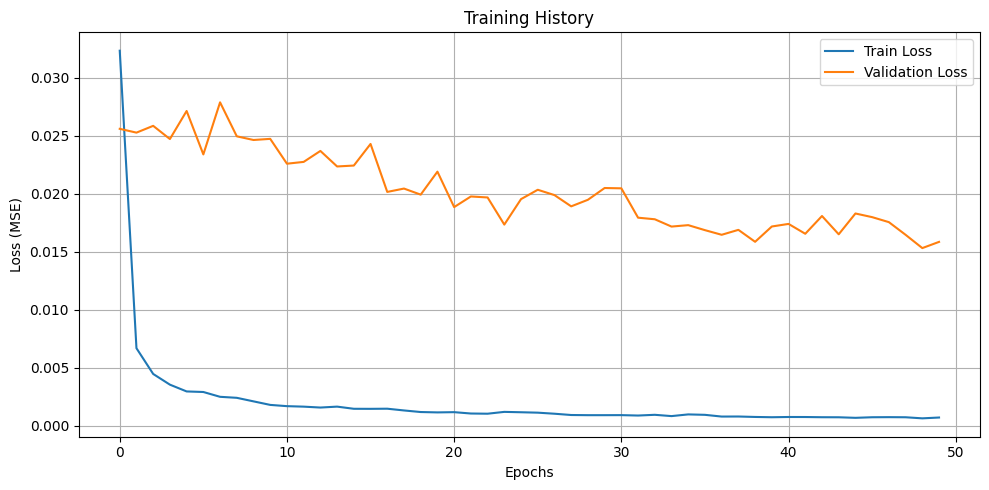


Training completed!
Best validation loss: 0.015328
Model saved as 'best_stock_lmu_model.pt'


In [10]:

# ============================================================================
# Main Script
# ============================================================================

if __name__ == "__main__":

    # Set random seeds
    SEED = 0
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Device configuration
    if torch.cuda.is_available():
        DEVICE = torch.device("cuda")
        torch.cuda.empty_cache()
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        DEVICE = torch.device("cpu")
        print("Using CPU")

    # ========================================================================
    # Configuration
    # ========================================================================

    # Stock tickers (10 major stocks)
    TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META',
               'TSLA', 'NVDA', 'JPM', 'V', 'WMT']

    # Date range
    END_DATE = datetime.now().strftime('%Y-%m-%d')
    START_DATE = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d')  # 3 years

    # Model hyperparameters
    SEQUENCE_LENGTH = 60  # Use 60 days to predict next day(s)
    PREDICTION_HORIZON = 1  # Predict 1 day ahead
    N_h = 128  # Hidden size
    N_m = 64   # Memory size
    THETA = SEQUENCE_LENGTH
    LEARN_A = False
    LEARN_B = False

    # Training hyperparameters
    N_b = 32  # Batch size
    N_epochs = 50
    LEARNING_RATE = 0.001
    TRAIN_SPLIT = 0.8  # 80% training, 20% validation

    # ========================================================================
    # Data Preparation
    # ========================================================================

    # Download stock data
    stock_data = download_stock_data(TICKERS, START_DATE, END_DATE)
    print(f"\nStock data shape: {stock_data.shape}")
    print(f"Columns: {list(stock_data.columns)}")

    # Convert to numpy and normalize
    data_array = stock_data.values
    normalized_data, min_val, max_val = normalize_data(data_array, method='minmax')

    # Split into train and validation
    split_idx = int(len(normalized_data) * TRAIN_SPLIT)
    train_data = normalized_data[:split_idx]
    val_data = normalized_data[split_idx:]

    print(f"\nTrain data: {train_data.shape}")
    print(f"Validation data: {val_data.shape}")

    # Create datasets
    train_dataset = StockDataset(train_data, SEQUENCE_LENGTH, PREDICTION_HORIZON)
    val_dataset = StockDataset(val_data, SEQUENCE_LENGTH, PREDICTION_HORIZON)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=N_b, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=N_b, shuffle=False)

    print(f"\nTraining samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # ========================================================================
    # Model Setup
    # ========================================================================

    N_x = len(TICKERS)  # Input size = number of stocks
    N_y = len(TICKERS)  # Output size = number of stocks

    model = StockPredictionModel(
        input_size=N_x,
        output_size=N_y,
        hidden_size=N_h,
        memory_size=N_m,
        theta=THETA,
        learn_a=LEARN_A,
        learn_b=LEARN_B,
        prediction_horizon=PREDICTION_HORIZON
    )
    model = model.to(DEVICE)

    countParameters(model)

    # ========================================================================
    # Training Setup
    # ========================================================================

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    # ========================================================================
    # Training Loop
    # ========================================================================

    print("\nStarting training...\n")

    best_val_loss = float('inf')

    for epoch in range(N_epochs):
        print(f"Epoch: {epoch+1:02}/{N_epochs:02}")

        train_loss = train(model, train_loader, optimizer, criterion, DEVICE)
        val_loss = validate(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_stock_lmu_model.pt')
            print("✓ Saved best model")

        print()

    # ========================================================================
    # Visualization
    # ========================================================================

    plt.figure(figsize=(10, 5))
    plt.plot(range(N_epochs), train_losses, label='Train Loss')
    plt.plot(range(N_epochs), val_losses, label='Validation Loss')
    plt.ylabel("Loss (MSE)")
    plt.xlabel("Epochs")
    plt.title("Training History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

    print(f"\nTraining completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Model saved as 'best_stock_lmu_model.pt'")


GENERATING VISUALIZATIONS

1. Plotting AAPL predictions...


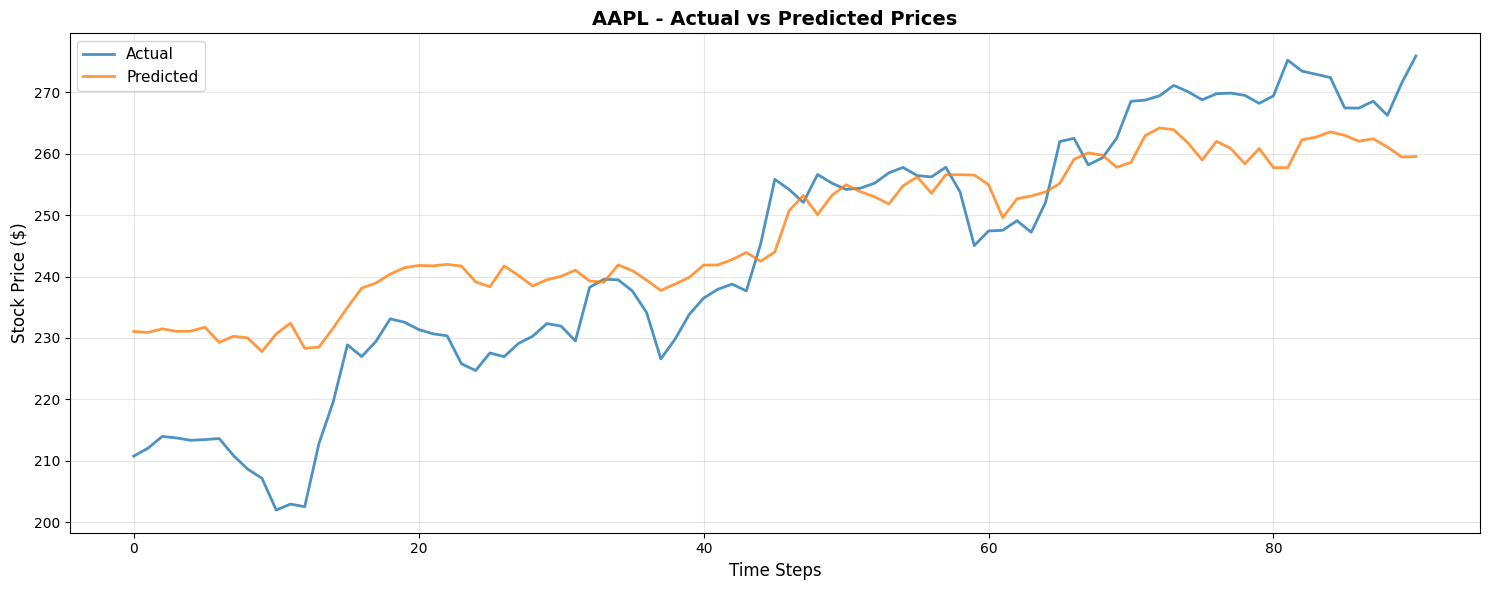


AAPL Metrics:
MSE: $123.39
MAE: $9.03
MAPE: 3.89%

2. Plotting all stocks...


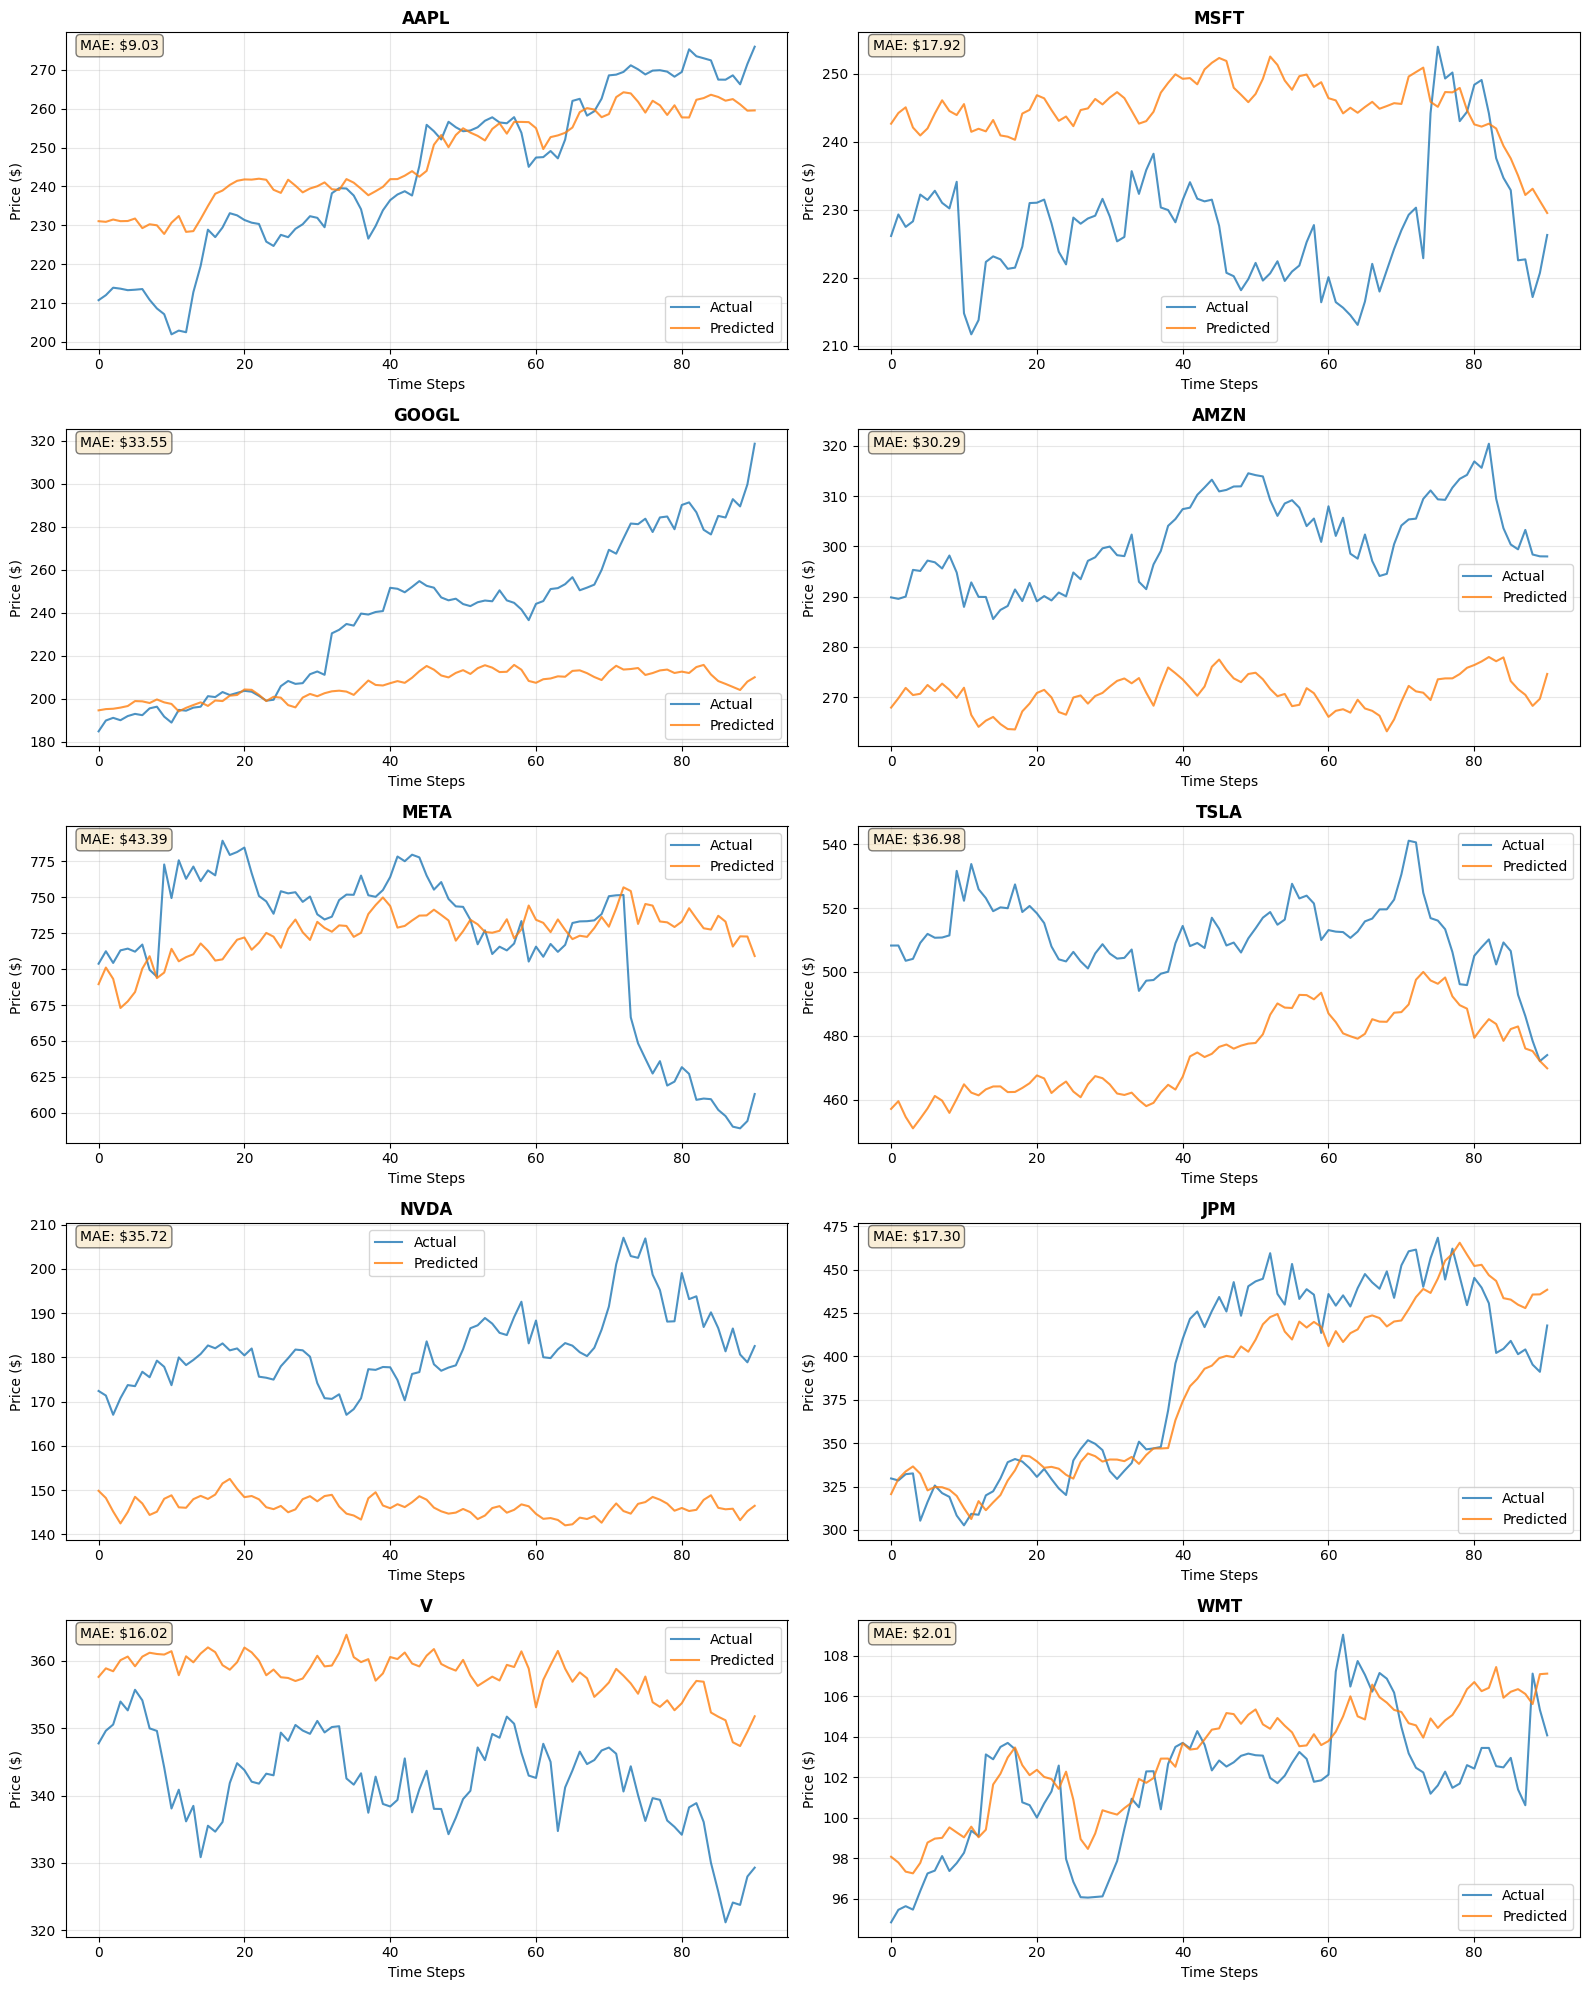


3. Generating error analysis...


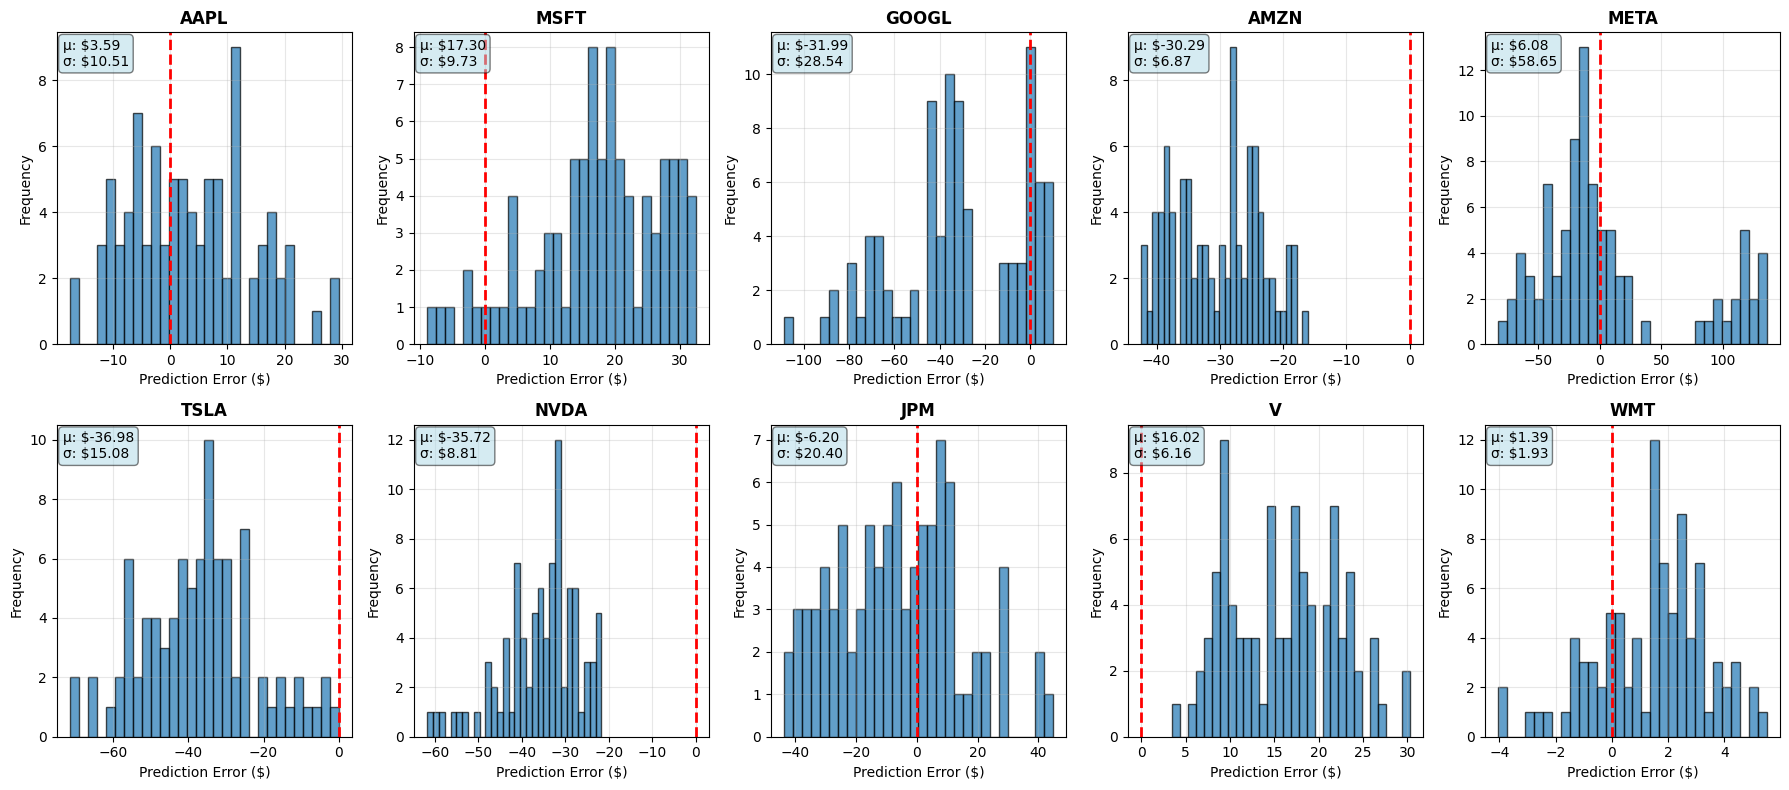


4. Generating scatter plots...


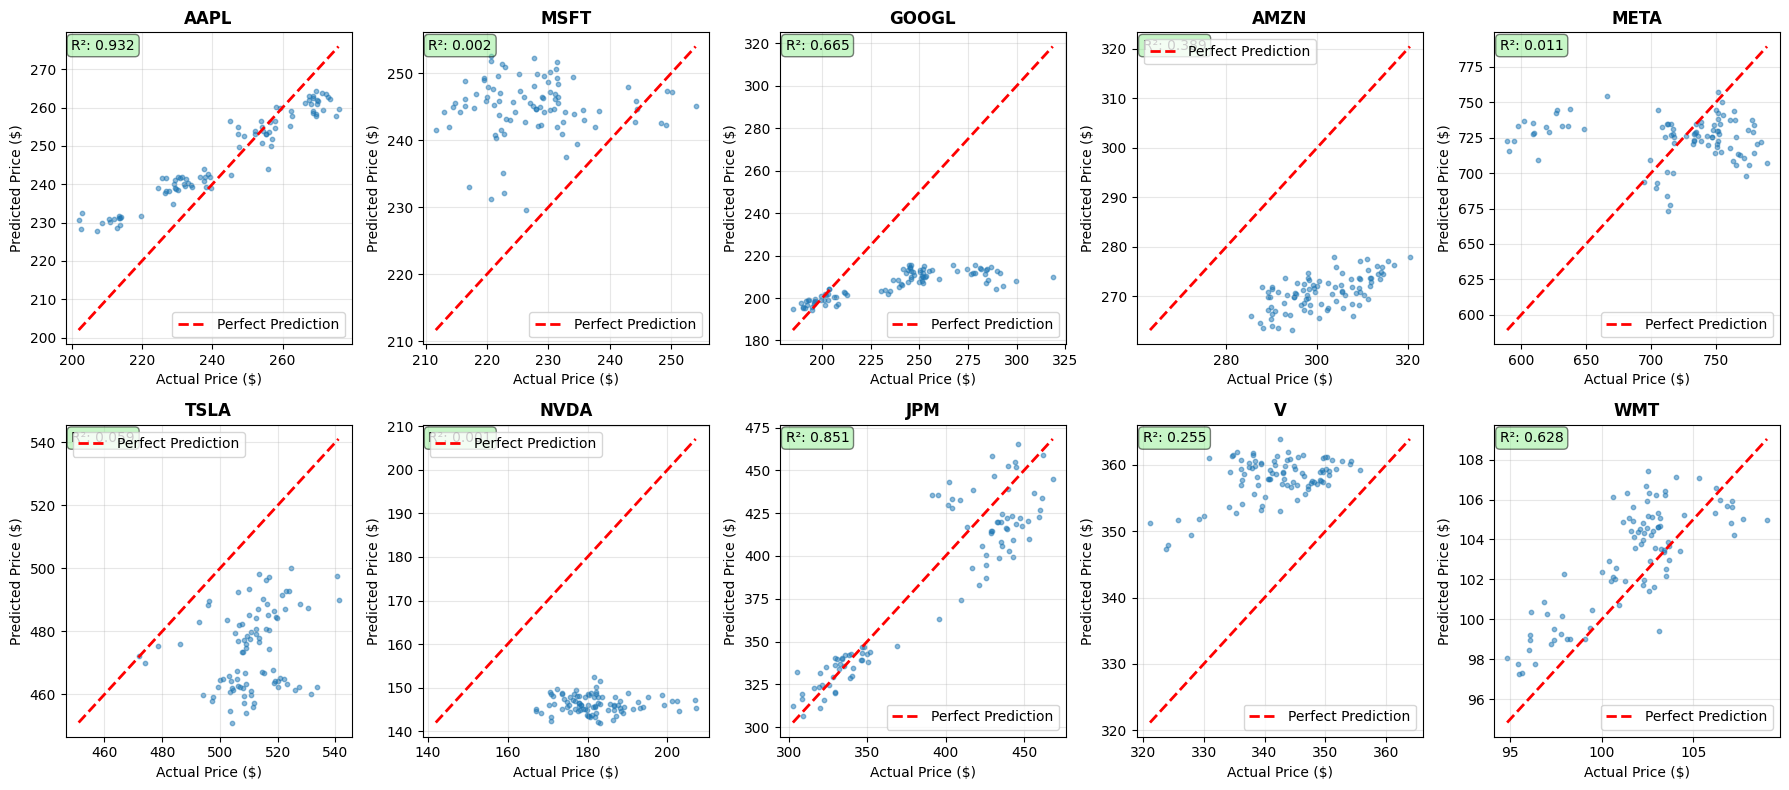


All visualizations saved!


In [11]:
# ============================================================================
# Stock Forecast Visualization
# Add this code after training is complete
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

def plot_predictions(model, dataset, device, min_val, max_val,
                     ticker_names, num_samples=200, stock_idx=0):
    """
    Plot predicted vs actual stock prices

    Args:
        model: trained model
        dataset: validation dataset
        device: torch device
        min_val, max_val: normalization parameters
        ticker_names: list of stock ticker names
        num_samples: number of timesteps to plot
        stock_idx: which stock to plot (0-9)
    """
    model.eval()

    # Create dataloader
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    predictions = []
    actuals = []

    with torch.no_grad():
        for i, (batch, targets) in enumerate(loader):
            if i >= num_samples:
                break

            batch = batch.to(device)
            output = model(batch)

            # Get prediction and actual for the specific stock
            pred = output[0].cpu().numpy()
            actual = targets[0].cpu().numpy()

            # Handle multi-dimensional outputs
            if len(pred.shape) > 1:
                pred = pred.flatten()
            if len(actual.shape) > 1:
                actual = actual.flatten()

            predictions.append(pred[stock_idx])
            actuals.append(actual[stock_idx])

    # Convert to numpy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Denormalize to get actual prices
    predictions_denorm = denormalize_data(predictions, min_val[stock_idx],
                                         max_val[stock_idx], method='minmax')
    actuals_denorm = denormalize_data(actuals, min_val[stock_idx],
                                     max_val[stock_idx], method='minmax')

    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(actuals_denorm, label='Actual', linewidth=2, alpha=0.8)
    plt.plot(predictions_denorm, label='Predicted', linewidth=2, alpha=0.8)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Stock Price ($)', fontsize=12)
    plt.title(f'{ticker_names[stock_idx]} - Actual vs Predicted Prices', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{ticker_names[stock_idx]}_predictions.png', dpi=300)
    plt.show()

    # Calculate metrics
    mse = np.mean((predictions_denorm - actuals_denorm) ** 2)
    mae = np.mean(np.abs(predictions_denorm - actuals_denorm))
    mape = np.mean(np.abs((actuals_denorm - predictions_denorm) / actuals_denorm)) * 100

    print(f"\n{ticker_names[stock_idx]} Metrics:")
    print(f"MSE: ${mse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return predictions_denorm, actuals_denorm


def plot_all_stocks(model, dataset, device, min_val, max_val,
                    ticker_names, num_samples=200):
    """
    Plot predictions for all stocks in a grid
    """
    model.eval()

    # Create dataloader
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_predictions = [[] for _ in range(len(ticker_names))]
    all_actuals = [[] for _ in range(len(ticker_names))]

    with torch.no_grad():
        for i, (batch, targets) in enumerate(loader):
            if i >= num_samples:
                break

            batch = batch.to(device)
            output = model(batch)

            pred = output[0].cpu().numpy()
            actual = targets[0].cpu().numpy()

            # Handle multi-dimensional outputs
            if len(pred.shape) > 1:
                pred = pred.flatten()
            if len(actual.shape) > 1:
                actual = actual.flatten()

            for stock_idx in range(len(ticker_names)):
                all_predictions[stock_idx].append(pred[stock_idx])
                all_actuals[stock_idx].append(actual[stock_idx])

    # Create subplots
    n_stocks = len(ticker_names)
    n_cols = 2
    n_rows = (n_stocks + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()

    for stock_idx in range(n_stocks):
        predictions = np.array(all_predictions[stock_idx])
        actuals = np.array(all_actuals[stock_idx])

        # Denormalize
        predictions_denorm = denormalize_data(predictions, min_val[stock_idx],
                                             max_val[stock_idx], method='minmax')
        actuals_denorm = denormalize_data(actuals, min_val[stock_idx],
                                         max_val[stock_idx], method='minmax')

        # Plot
        axes[stock_idx].plot(actuals_denorm, label='Actual', linewidth=1.5, alpha=0.8)
        axes[stock_idx].plot(predictions_denorm, label='Predicted', linewidth=1.5, alpha=0.8)
        axes[stock_idx].set_xlabel('Time Steps')
        axes[stock_idx].set_ylabel('Price ($)')
        axes[stock_idx].set_title(f'{ticker_names[stock_idx]}', fontweight='bold')
        axes[stock_idx].legend()
        axes[stock_idx].grid(True, alpha=0.3)

        # Calculate metrics
        mae = np.mean(np.abs(predictions_denorm - actuals_denorm))
        axes[stock_idx].text(0.02, 0.98, f'MAE: ${mae:.2f}',
                            transform=axes[stock_idx].transAxes,
                            verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Hide any unused subplots
    for idx in range(n_stocks, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('all_stocks_predictions.png', dpi=300)
    plt.show()


def plot_error_analysis(model, dataset, device, min_val, max_val, ticker_names):
    """
    Plot error distribution and error over time
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_errors = [[] for _ in range(len(ticker_names))]

    with torch.no_grad():
        for batch, targets in loader:
            batch = batch.to(device)
            output = model(batch)

            pred = output[0].cpu().numpy()
            actual = targets[0].cpu().numpy()

            if len(pred.shape) > 1:
                pred = pred.flatten()
            if len(actual.shape) > 1:
                actual = actual.flatten()

            for stock_idx in range(len(ticker_names)):
                # Denormalize
                pred_denorm = denormalize_data(pred[stock_idx], min_val[stock_idx],
                                              max_val[stock_idx], method='minmax')
                actual_denorm = denormalize_data(actual[stock_idx], min_val[stock_idx],
                                                max_val[stock_idx], method='minmax')
                error = pred_denorm - actual_denorm
                all_errors[stock_idx].append(error)

    # Plot error distributions
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.flatten()

    for stock_idx in range(len(ticker_names)):
        errors = np.array(all_errors[stock_idx])

        axes[stock_idx].hist(errors, bins=30, edgecolor='black', alpha=0.7)
        axes[stock_idx].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[stock_idx].set_xlabel('Prediction Error ($)')
        axes[stock_idx].set_ylabel('Frequency')
        axes[stock_idx].set_title(f'{ticker_names[stock_idx]}', fontweight='bold')
        axes[stock_idx].grid(True, alpha=0.3)

        # Add statistics
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        axes[stock_idx].text(0.02, 0.98, f'μ: ${mean_error:.2f}\nσ: ${std_error:.2f}',
                            transform=axes[stock_idx].transAxes,
                            verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    plt.tight_layout()
    plt.savefig('error_distributions.png', dpi=300)
    plt.show()


def plot_prediction_scatter(model, dataset, device, min_val, max_val,
                            ticker_names, num_samples=None):
    """
    Scatter plot of predicted vs actual values for all stocks
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    all_predictions = [[] for _ in range(len(ticker_names))]
    all_actuals = [[] for _ in range(len(ticker_names))]

    with torch.no_grad():
        for i, (batch, targets) in enumerate(loader):
            if num_samples and i >= num_samples:
                break

            batch = batch.to(device)
            output = model(batch)

            pred = output[0].cpu().numpy()
            actual = targets[0].cpu().numpy()

            if len(pred.shape) > 1:
                pred = pred.flatten()
            if len(actual.shape) > 1:
                actual = actual.flatten()

            for stock_idx in range(len(ticker_names)):
                pred_denorm = denormalize_data(pred[stock_idx], min_val[stock_idx],
                                              max_val[stock_idx], method='minmax')
                actual_denorm = denormalize_data(actual[stock_idx], min_val[stock_idx],
                                                max_val[stock_idx], method='minmax')
                all_predictions[stock_idx].append(pred_denorm)
                all_actuals[stock_idx].append(actual_denorm)

    # Create scatter plots
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.flatten()

    for stock_idx in range(len(ticker_names)):
        predictions = np.array(all_predictions[stock_idx])
        actuals = np.array(all_actuals[stock_idx])

        axes[stock_idx].scatter(actuals, predictions, alpha=0.5, s=10)

        # Perfect prediction line
        min_val_plot = min(actuals.min(), predictions.min())
        max_val_plot = max(actuals.max(), predictions.max())
        axes[stock_idx].plot([min_val_plot, max_val_plot],
                            [min_val_plot, max_val_plot],
                            'r--', linewidth=2, label='Perfect Prediction')

        axes[stock_idx].set_xlabel('Actual Price ($)')
        axes[stock_idx].set_ylabel('Predicted Price ($)')
        axes[stock_idx].set_title(f'{ticker_names[stock_idx]}', fontweight='bold')
        axes[stock_idx].legend()
        axes[stock_idx].grid(True, alpha=0.3)

        # Calculate R²
        correlation_matrix = np.corrcoef(actuals, predictions)
        r_squared = correlation_matrix[0, 1] ** 2
        axes[stock_idx].text(0.02, 0.98, f'R²: {r_squared:.3f}',
                            transform=axes[stock_idx].transAxes,
                            verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    plt.tight_layout()
    plt.savefig('prediction_scatter.png', dpi=300)
    plt.show()


# ============================================================================
# Usage Example - Add this after training
# ============================================================================

# Load the best model
model.load_state_dict(torch.load('best_stock_lmu_model.pt'))

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# 1. Plot a single stock (e.g., Apple)
print("\n1. Plotting AAPL predictions...")
plot_predictions(model, val_dataset, DEVICE, min_val, max_val,
                TICKERS, num_samples=200, stock_idx=0)

# 2. Plot all stocks in a grid
print("\n2. Plotting all stocks...")
plot_all_stocks(model, val_dataset, DEVICE, min_val, max_val,
               TICKERS, num_samples=200)

# 3. Error analysis
print("\n3. Generating error analysis...")
plot_error_analysis(model, val_dataset, DEVICE, min_val, max_val, TICKERS)

# 4. Scatter plots
print("\n4. Generating scatter plots...")
plot_prediction_scatter(model, val_dataset, DEVICE, min_val, max_val,
                       TICKERS, num_samples=200)

print("\n" + "="*70)
print("All visualizations saved!")
print("="*70)